## Assignment #1 Face Recognition

In [1]:
import cv2 as cv
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def classify_knn(train_x, train_y, test_x, test_y, k=1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_x, train_y)
    accuracy = knn.score(test_x, test_y)
    return accuracy

### 1. Download the Dataset and Understand the Format (10 points)

In [74]:
# Initialize an empty dictionary to store the loaded images
faces = {}

# Open the Zip archive and iterate over the files
with zipfile.ZipFile("archive.zip") as folder:
    for filename in folder.namelist():

        # Check if the file is a PGM image
        if filename.endswith('.pgm'):

            # Open the file and read its contents into a buffer
            with folder.open(filename) as image:
                arr = np.frombuffer(image.read(), np.uint8)

            # Decode the buffer as a grayscale image using OpenCV
            # and store it in the dictionary
            faces[filename] = cv.imdecode(arr, cv.IMREAD_GRAYSCALE)

In [75]:
#The dimensions of a random image from the dictionary
faces['s12/8.pgm'].shape

(112, 92)

In [76]:
#Example of the filenames stored as the key values in the faces dictionary
file_names = list(faces.keys())
print(file_names[:5])

['s1/1.pgm', 's1/10.pgm', 's1/2.pgm', 's1/3.pgm', 's1/4.pgm']


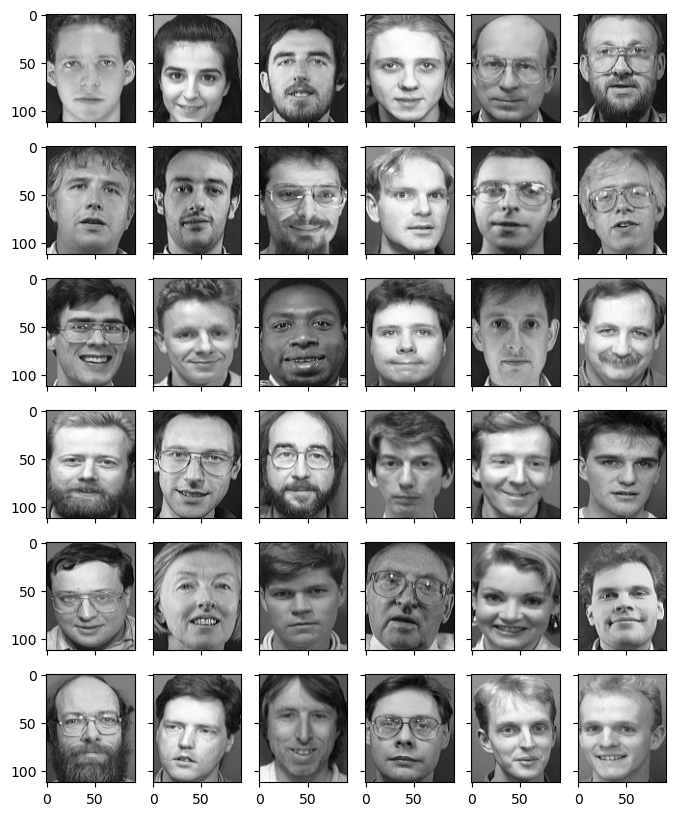

In [77]:
# Create a figure with a 6x6 grid of subplots that share the same x and y axes
figure, axis = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 10))

# Initialize an empty list to store the images to plot, 10 steps each time to cover as many faces as possible
images = []
for i in range(36):
    images.append(list(faces.values())[i * 10])
for i in range(36):
    row = i // 6
    col = i % 6
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

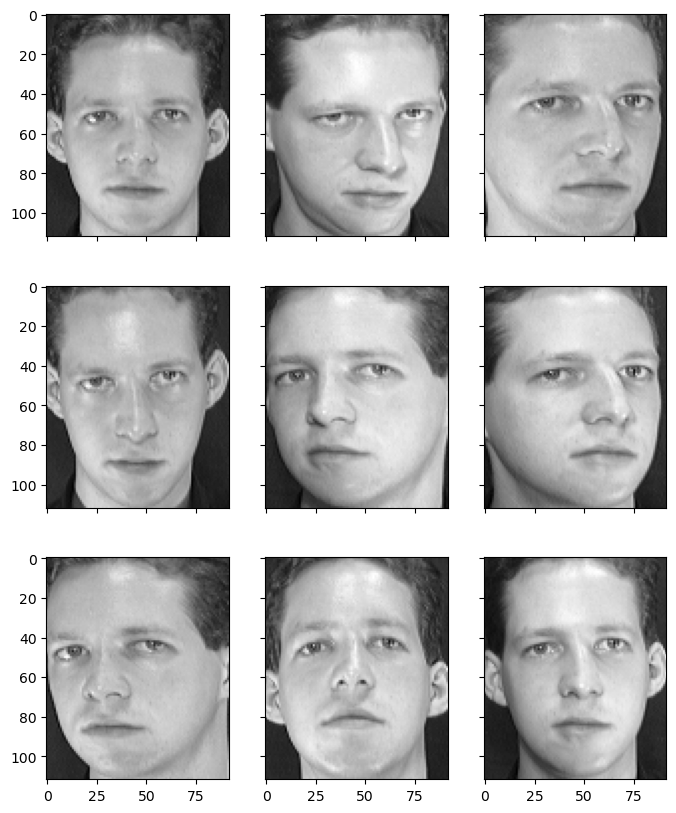

In [78]:
figure, axis = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8, 10))
images = []
for i in range(9):
    images.append(list(faces.values())[i])

# Display 9 images for the same subject to get an idea of how data looks like
for i in range(9):
    row = i // 3
    col = i % 3
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

### 2. Generate the Data Matrix and the Label vector (10 points)

In [79]:
#Get the dimensions of the grayscale image
n_x = faces[file_names[0]].shape[0]
n_y = faces[file_names[0]].shape[1]

#Initialize the data matrix array to stack the samples
data = np.empty((n_x*n_y, 0))

#Initialize list of classes
label = []
for i in range(len(faces.keys())):
    faces[file_names[i]]=faces[file_names[i]].reshape(n_x*n_y,1)
    data = np.hstack((data,faces[file_names[i]]))
    label.append(file_names[i].split("/")[0][1:])
label = np.array(label).reshape((400,1))

In [80]:
data.shape

(10304, 400)

In [81]:
label.shape

(400, 1)

### 3. Split the Dataset into Training and Testing Test sets (10 points)

In [82]:
#Split the Dataset, even rows for testing and odd for training
test_x = data.T[::2]
test_y = label[::2]
train_x = data.T[1::2]
train_y = label[1::2]

In [12]:
test_x.shape

(200, 10304)

In [13]:
test_y.shape

(200, 1)

In [14]:
train_x.shape

(200, 10304)

In [15]:
train_y.shape

(200, 1)

### 4. Classification using PCA

<img src="pca.png" width="80%" height="80%" />


In [16]:
alpha = [0.8,0.85,0.9,0.95]

In [17]:
mu = np.mean(train_x,axis=0,keepdims=True)
mu.shape

(1, 10304)

In [18]:
Z = train_x - mu
Z.shape

(200, 10304)

In [19]:
cov = np.matmul(Z.T,Z)
cov /= Z.shape[0]
cov.shape

(10304, 10304)

In [107]:
eigen_values, eigen_vectors = np.linalg.eigh(cov)

In [108]:
#Sort eigen vectors according to the descending order of corresponding eigen values
idx = eigen_values.argsort()[::-1]
eigen_values = eigen_values[idx]
eigen_vectors = eigen_vectors[:,idx]

In [22]:
sum_eigen = float(np.sum(eigen_values))

In [23]:
#Choose the number of eigen vectors in the eigen face according to the accuracy we defined, we have an array alphas of all
#accuracies desired, we return a corresponding array with the number of eigen vectors starting from 0
var = 0
num_eigen = 0
final_rank = []
temp_sum = 0
for i in alpha:
    while var < i:
        temp_sum += eigen_values[num_eigen]
        var = temp_sum/sum_eigen
        num_eigen += 1
    final_rank.append(num_eigen)
    var=0
    num_eigen=0
    temp_sum=0
print(final_rank)

[36, 52, 76, 117]


In [122]:
#Get the projection matrix using the first alpha (Accuracy threshold)
projection = eigen_vectors[:,:final_rank[0]]

In [123]:
train_x.shape

(200, 10304)

In [124]:
projection.shape

(10304, 36)

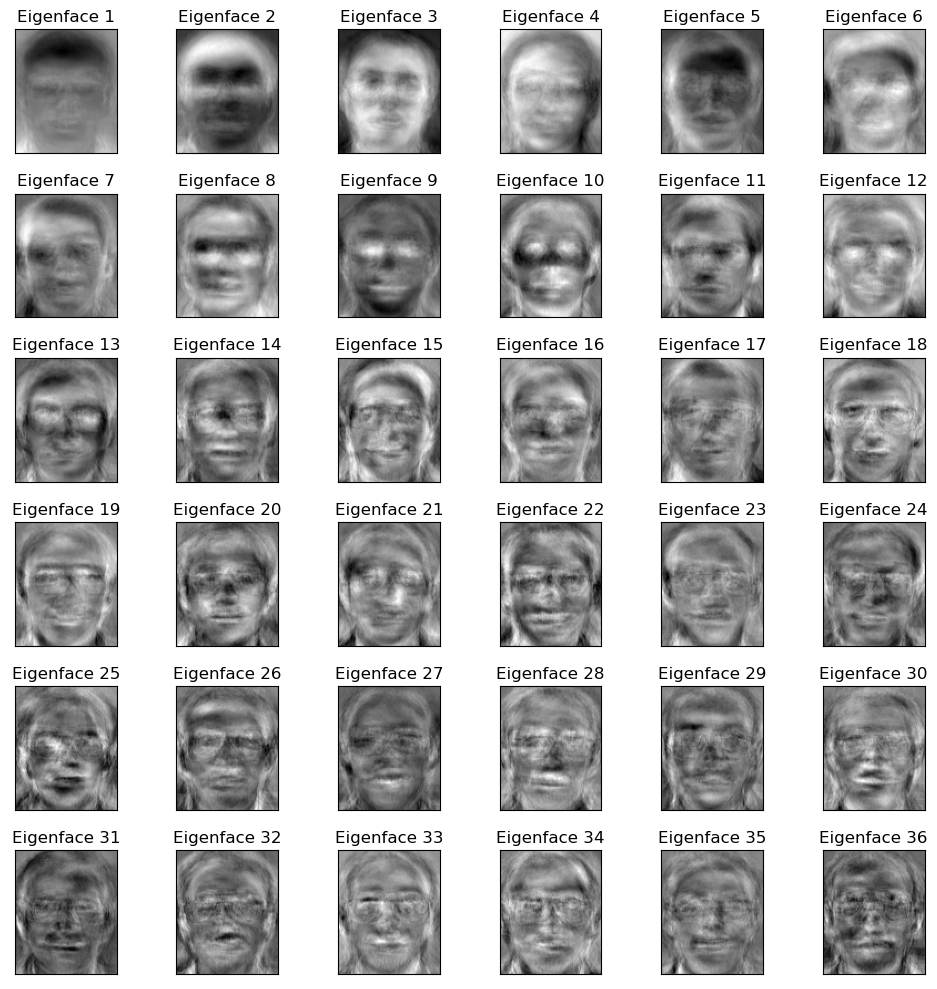

In [28]:
# Plot the eigenfaces
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(10, 10))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        index = i * 6 + j
        eigenface = eigen_vectors[:, index]
        col.imshow(eigenface.reshape(112, -1), cmap='gray')
        col.set_xticks([])
        col.set_yticks([])
        col.set_title(f"Eigenface {index+1}")
fig.tight_layout()
plt.show()

In [30]:
#Get the accuracy with respect to each alpha using KNN with 1 neighbor
print(f'K = 1')
accuracy = {}

#Get the centered train and test to project them to the new dimensions represented as the projection matrix
train_x1 = train_x - mu
test_x1 = test_x - mu
for i in range(len(final_rank)):
    projection = eigen_vectors[:,:final_rank[i]]
    train_x_new= np.dot(train_x1,projection)
    test_x_new= np.dot(test_x1,projection)
    org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=1)
    accuracy[alpha[i]] = org_accuracy
print(accuracy)

K = 1
{0.8: 0.94, 0.85: 0.945, 0.9: 0.94, 0.95: 0.935}


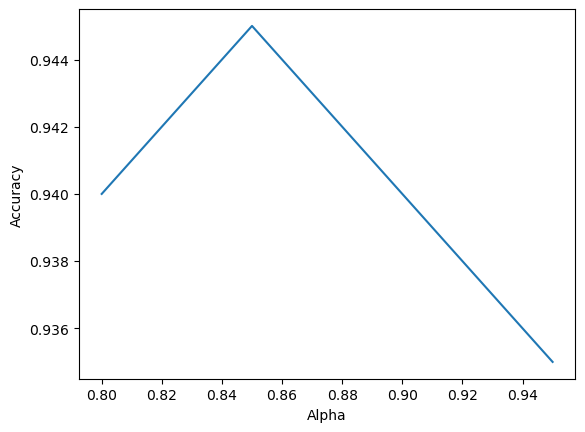

In [31]:
#plot the alpha values against the accuracy
x = accuracy.keys()
y = accuracy.values()
plt.plot(x, y)
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

### 5. Classification using LDA

In [68]:
train_x.shape

(200, 10304)

In [69]:
train_y.shape

(200, 1)

In [70]:
train_y = np.array(train_y)

In [71]:
train_y.shape

(200, 1)

In [83]:
train_y_int = train_y.astype(int)

In [84]:
train_y_new = train_y_int.reshape(-1)

In [85]:
# Calculate the mean vector for every class [1-40]
means = np.zeros((40,10304))
for i in range(1,41):
    means[i-1] = np.mean(train_x[train_y_new == i],axis=0,keepdims=True)

In [86]:
means.shape

(40, 10304)

In [87]:
mu.shape

(10304, 1)

In [88]:
# Calculate between class scatter matrix
m = 40 # number of classes
k = 5 # number of samples per class
N = 10304 # number of features

#Initialize the between class scatter matrix to 0 having the dimensions of features x features
Sb = np.zeros((train_x.shape[1],train_x.shape[1]))
mu = mu.reshape(N, 1)
for mean in means:
    mean = mean.reshape(N, 1)
    Sb += k*np.dot((mean-mu),(mean-mu).T)
Sb.shape

(10304, 10304)

In [45]:
# Subtract the mean from each class
# Center data class matrices
Z = []
for i, mean in enumerate(means):
    idx = i+1
    mean = mean.reshape(1,N)
    
    #Query the train_x matrix using the train_y value to get the class then subtracting the mean of the corresponding class
    Z.append(train_x[train_y_new == idx] - mean)

In [47]:
Z_all = np.array(Z).reshape(-1,np.shape(Z)[-1])

In [125]:
Z_all.shape

(200, 10304)

In [49]:
#Initialize the total scatter matrix to 0
S = np.zeros((N,N))
for i in range(40):
    Z_arr = np.array(Z[i])
    S += (Z_arr.T).dot(Z_arr)

In [51]:
S_inverse=np.linalg.inv(S)

In [126]:
eigen_values_2,eigen_vectors_2 = np.linalg.eigh(np.dot(S_inverse,Sb)) 

In [127]:
#Sort eigen vectors according to the descending order of corresponding eigen values
idx = eigen_values_2.argsort()[::-1]
eigen_values_2 = eigen_values_2[idx]
eigen_vectors_2 = eigen_vectors_2[:,idx]
p = eigen_vectors_2[:,:39]

In [128]:
p.shape

(10304, 39)

In [130]:
#Projecting the train_x and test_x to the new dimensions(39 eigen vector) and fininding the accuracy of the LDA using KNN
print(f'K = 1')
d_train_x_new= np.dot(train_x,p)
d_test_x_new= np.dot(test_x,p)
org_accuracy = classify_knn(d_train_x_new, train_y, d_test_x_new, test_y,1)
print(f'Accuracy: {org_accuracy}')

K = 1
Accuracy: 0.95


### 6. Classifier Tuning

Tie breaking is done using the default rue of the sklearn library

In [109]:
#Find the accuracy for each number of neighbors in the KNN array for the different values of alphas
#Using original data not the centered data (both lead to the same results)
KNN = [1,3,5,7]
best_acc = []
for j in range(4):
    print(f'K = {KNN[j]}')
    accuracy = {}
    for i in range(len(final_rank)):
        projection = eigen_vectors[:,:final_rank[i]]
        train_x_new= np.dot(train_x,projection)
        test_x_new= np.dot(test_x,projection)
        org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=KNN[j])
        accuracy[alpha[i]] = org_accuracy
        if alpha[i] == 0.95:
            best_acc.append(org_accuracy)
    print(accuracy)
print(best_acc)

K = 1
{0.8: 0.94, 0.85: 0.945, 0.9: 0.94, 0.95: 0.935}
K = 3
{0.8: 0.84, 0.85: 0.86, 0.9: 0.875, 0.95: 0.885}
K = 5
{0.8: 0.815, 0.85: 0.795, 0.9: 0.8, 0.95: 0.785}
K = 7
{0.8: 0.765, 0.85: 0.785, 0.9: 0.765, 0.95: 0.775}
[0.935, 0.885, 0.785, 0.775]


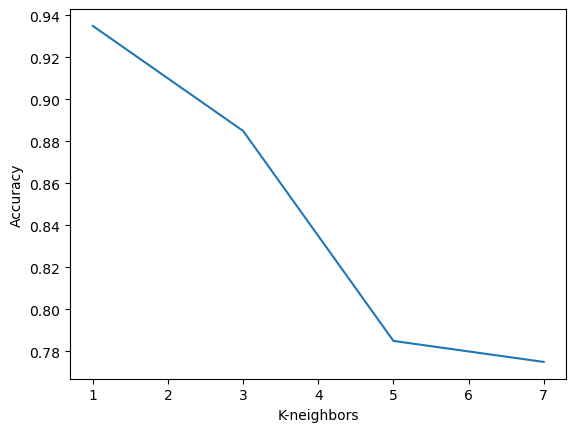

In [111]:
#plotting PCA accuracy of the highest alpha against number of neighbors
x = KNN
y = best_acc
plt.plot(x, y)
plt.xlabel("K-neighbors")
plt.ylabel("Accuracy")
plt.show()

In [131]:
#Find the accuracy for each number of neighbors in the KNN array
KNN = [1,3,5,7]
LDA_accuracies=[]
for j in range(4):
    print(f'K = {KNN[j]}')
    train_x_new= np.dot(train_x,p)
    test_x_new= np.dot(test_x,p)
    org_accuracy = classify_knn(train_x_new, train_y, test_x_new, test_y, k=KNN[j])
    print(f"Accuracy={org_accuracy}")
    LDA_accuracies.append(org_accuracy)
print(LDA_accuracies)

K = 1
Accuracy=0.95
K = 3
Accuracy=0.895
K = 5
Accuracy=0.85
K = 7
Accuracy=0.805
[0.95, 0.895, 0.85, 0.805]


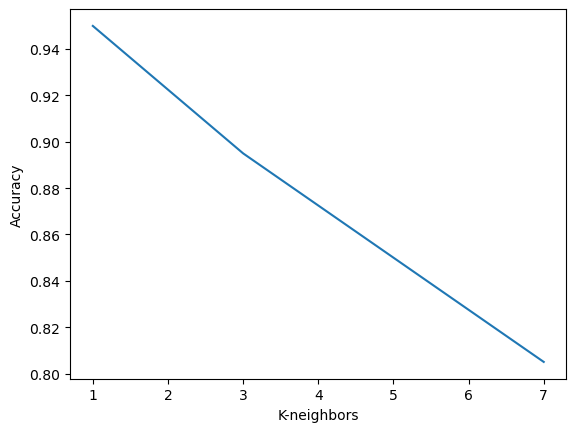

In [132]:
#plotting LDA accuracy against number of neighbors
x = KNN
y = LDA_accuracies
plt.plot(x, y)
plt.xlabel("K-neighbors")
plt.ylabel("Accuracy")
plt.show()

### 7. Compare vs Non-Face Images

In [91]:
# Initialize an empty dictionary to store the loaded images
non_faces = {}

# Open the Zip archive and iterate over the files
with zipfile.ZipFile("non_image.zip") as folder:
    for filename in folder.namelist():

        # Check if the file is a PGM image
        if filename.endswith('.jpg'):

            # Open the file and read its contents into a buffer
            with folder.open(filename) as image:
                arr = np.frombuffer(image.read(), np.uint8)

            # Decode the buffer as a grayscale image using OpenCV
            # and store it in the dictionary
            non_faces[filename] = cv.imdecode(arr, cv.IMREAD_GRAYSCALE)
            non_faces[filename] = cv.resize(non_faces[filename] , (92, 112))


In [92]:
non_faces['non_image/airplane/airplane_0003.jpg'].shape

(112, 92)

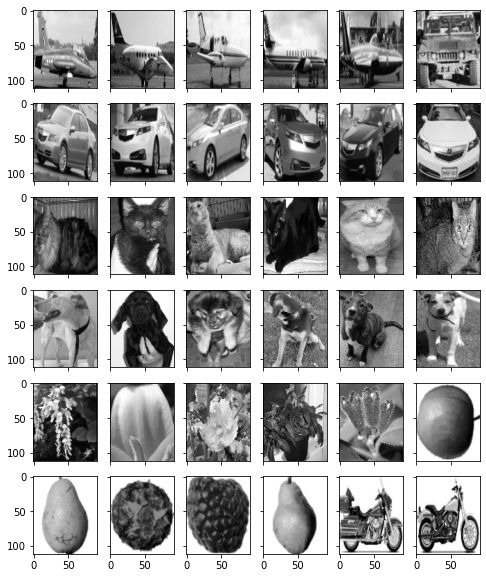

In [96]:
# Create a figure with a 6x6 grid of subplots that share the same x and y axes
figure, axis = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(8, 10))

# Initialize an empty list to store the images to plot, 10 steps each time to cover as many faces as possible
images = []
for i in range(36):
    images.append(list(non_faces.values())[i * 10])
for i in range(36):
    row = i // 6
    col = i % 6
    axis[row][col].imshow(images[i], cmap='gray')
plt.show()

In [97]:
len(non_faces.keys())

400

In [105]:
file_names = list(non_faces.keys())

#Get the dimensions of the grayscale image
n_x = non_faces[file_names[0]].shape[0]
n_y = non_faces[file_names[0]].shape[1]

#Initialize the data matrix array to stack the samples
data_non_faces = np.empty((n_x*n_y, 0))

#Initialize list of classes
label = []
for i in range(len(non_faces.keys())):
    non_faces[file_names[i]]=non_faces[file_names[i]].reshape(n_x*n_y,1)
    data_non_faces = np.hstack((data_non_faces,non_faces[file_names[i]]))
    label.append(file_names[i].split("/")[0][1:])

In [106]:
test_x_non_faces = data_non_faces.T[::2]
train_x_non_faces = data_non_faces.T[1::2]

In [109]:
test_y_faces = np.ones((200,1))
train_y_faces = np.ones((200,1))
test_y_non_faces = np.zeros((200,1))
train_y_non_faces = np.zeros((200,1))

In [108]:
test_x.shape

(200, 10304)

In [110]:
test_x_non_faces.shape

(200, 10304)

In [113]:
train_x=np.vstack((train_x,train_x_non_faces))
test_x=np.vstack((test_x,test_x_non_faces))
test_y=np.vstack((test_y_faces,test_y_non_faces))
train_y=np.vstack((train_y_faces,train_y_non_faces))

In [157]:
# Class for PCA
class PCA():
    def __init__(self):
        print("Starting PCA")
        pass
    
    def compute_mean(self):
        self.mean = np.mean(self.data,axis=0,keepdims=True)
#         print(self.mean.shape)
    def center(self):
        self.Z = self.data - self.mean
#         print(self.Z.shape)
        
    def cov(self):
        self.covar = (self.Z.T).dot(self.Z)
        self.covar /= self.Z.shape[0]
        print(self.covar.shape)
        
    def eigen_decomp(self):
        self.eigen_val,self.eigen_vector = np.linalg.eigh(self.covar)
        idx = self.eigen_val.argsort()[::-1]
        self.eigen_val = self.eigen_val[idx]
        self.eigen_vector = self.eigen_vector[:,idx]
        
    def project(self):
        self.test_x = test_x
    
    def reduce(self,alpha):
        self.alpha = alpha
        var = 0
        num_eigen = 0
        final_rank = []
        temp_sum = 0
        while var < self.alpha:
            temp_sum += self.eigen_val[num_eigen]
            var = temp_sum/sum_eigen
            num_eigen += 1
        self.dimensions = num_eigen
        print(self.dimensions)

    def project(self,test):
        self.test_x = test
        self.projection=self.eigen_vector[:,:self.dimensions]
        self.new_train_x=self.data.dot(self.projection)
        self.new_test_x=self.test_x.dot(self.projection)
    
    def classify(self,k,test_y,train_y):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(self.new_train_x, train_y)
        accuracy = knn.score(self.new_test_x, test_y)
        print(f"Accuracy: {accuracy}")
        
    def start(self,data):
        self.data = data
        self.compute_mean()
        self.center()
        self.cov()
        self.eigen_decomp()
    

In [159]:
pca = PCA()
pca.start(train_x)
pca.reduce(0.99)
pca.project(test_x)
pca.classify(7,test_y,train_y)

Starting PCA
(10304, 10304)
2
Accuracy: 0.8925


### 8. Bonus